## Model evaluation

  Notebook loads trained model and compare the produced PMF with the analytical result

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../scripts')))

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import torch

from scipy.constants import physical_constants
from scipy.constants import Boltzmann as kb
from utils import MorseOscillator

/home/iryna/miniconda3/envs/ML8/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# List of models to use 
root  = '../03_models'
models = [f'{root}/{i}00' for i in [1, 3, 6]]
temperatures = [i*100 for i in [1, 3, 6]]

In [11]:
r0 = 1.8323926 # a.u.
D = 0.18748511263179304 # a.u.
a = 1.1562696428501682 # a.u.
reduced_mass = 1728.3071 # a. u.
oscillator = MorseOscillator(D, a, reduced_mass)
P = 64

In [12]:
# Test coordinates
x_min = 1.1
x_max = 3.0
n_points = 1000

x = np.linspace(x_min, x_max, n_points)

In [13]:
def get_test_coordinates(x_min=0, x_max=5, n_points=1000):
    x = np.linspace(x_min, x_max, n_points)
    test_coordinates = np.zeros((len(x), 3), dtype=np.float32)
    test_coordinates[:, 0] = x
    test_coordinates = torch.tensor(test_coordinates, requires_grad=True)
    return test_coordinates

/home/iryna/miniconda3/envs/ML8/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.5.0 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


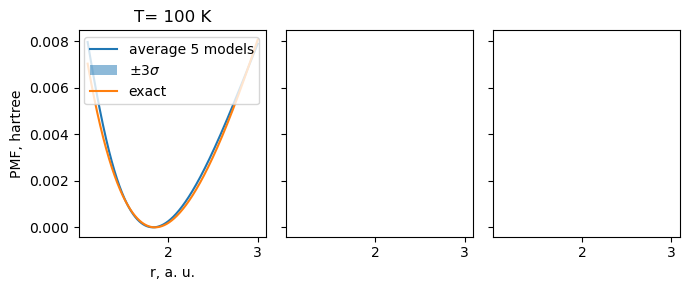

In [14]:
J_PER_HARTREE = physical_constants['atomic unit of energy']

fig, ax = plt.subplots(1,3, figsize=(7,3.0), sharex=True, sharey=True)
ax = ax.flatten()
ax_ndx = 0
for ndx, model_folder in enumerate(models):
    # Calculate basic potential
    T = temperatures[ndx]
    beta = J_PER_HARTREE[0]/(T*kb)
    pmf = oscillator.pmf(beta, x-r0) 
    pmf_predicted_total = []
    for fold_ndx in range(5):
        test_coordinates = get_test_coordinates(x_min, x_max, n_points)
        with open(f'{model_folder}/optimized_model_fold_{fold_ndx}.pkl', 'rb') as f:
            model = pickle.load(f)
        correction = model.calculate_potential(test_coordinates)
        pmf_predicted = oscillator.potential(x-r0)/P + correction
        pmf_predicted_corrected = pmf_predicted - np.min(pmf_predicted)
        pmf_predicted_total.append(pmf_predicted_corrected)
    pmf_predicted_total = np.array(pmf_predicted_total)
    pmf_predicted_mean = np.mean(pmf_predicted_total, axis=0) 
    pmf_predicted_std = np.std(pmf_predicted_total, axis=0)
    lower_bound = pmf_predicted_mean - 3*pmf_predicted_std
    upper_bound = pmf_predicted_mean + 3*pmf_predicted_std
    ax[ax_ndx].plot(x, pmf_predicted_mean, label='average 5 models')
    ax[ax_ndx].fill_between(x, lower_bound, upper_bound, alpha=0.5, label=r'$\pm 3 \sigma$')
    ax[ax_ndx].plot(x, pmf - np.min(pmf), label='exact')
    ax[ax_ndx].set_title(f"T= {T} K")
    ax[ax_ndx].set_xlabel('r, a. u.')
    ax[ax_ndx].set_ylabel('PMF, hartree')
    ax_ndx += 1
ax[0].legend(loc='best')
temperatures = np.array(temperatures)
plt.tight_layout()

## Analyze model, trained with recycled data

In [8]:
# load data
def plot_model(model_folder, T_0, T_1, mass_0, mass_1):
    """Plot reference data, and model prediction. Take 
        temperature and masses from the config file
    """
    oscillator_ref = MorseOscillator(D, a, mass_0)
    oscillator_target = MorseOscillator(D, a, mass_1)
    
    x = np.linspace(1.1, 3.0, 1000)
    beta_0 = J_PER_HARTREE[0]/(T_0*kb)
    beta_1 = J_PER_HARTREE[0]/(T_1*kb)
    
    pmf_ref = oscillator_ref.pmf(beta_0, x-r0)
    pmf_target = oscillator_target.pmf(beta_1, x-r0)
    
    pmf_predicted_total = []
    for fold_ndx in range(5):
        # Initialize test coordinates. Probably, need to redo it every time
        # since gradient tree is kept
        # Test set of coordinates
        test_coordinates = get_test_coordinates(x_min, x_max, n_points)
        with open(f'{model_folder}/optimized_model_fold_{fold_ndx}.pkl', 'rb') as f:
            model = pickle.load(f)
        correction = model.calculate_potential(test_coordinates)
        pmf_predicted = oscillator_target.potential(x-r0)/P + correction
        pmf_predicted_corrected = pmf_predicted - np.min(pmf_predicted)
        pmf_predicted_total.append(pmf_predicted_corrected)
    pmf_predicted_total = np.array(pmf_predicted_total)
    pmf_predicted_mean = np.mean(pmf_predicted_total, axis=0)
    pmf_predicted_std = np.std(pmf_predicted_total, axis=0)
    lower_bound = pmf_predicted_mean - 3*pmf_predicted_std
    upper_bound = pmf_predicted_mean + 3*pmf_predicted_std
    return x, pmf_predicted_mean, lower_bound, upper_bound, pmf_ref, pmf_target

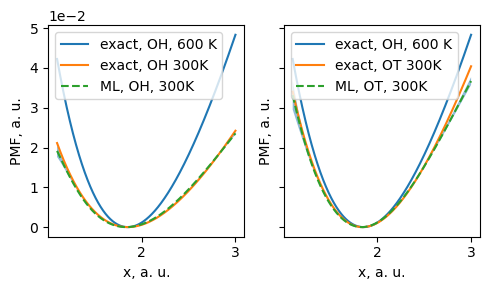

In [9]:
fig, ax = plt.subplots(1,2, figsize=(5,3.0), sharex=True, sharey=True)


# Add data for the right panel
root = '../05_force_rescaling/models'
exp_list = ['300K_H', '300K_T'] 
mass_list = [1728.3071, 4625.8933]
isotopes = ['H', 'T']
t_ref  = 600 # K, temperature used to run PIMD simulation
t_target = 300 # K, temperature used to train model
isotope_ref = 'H'

for ndx, exp in enumerate(exp_list):
    exp_folder = f'{root}/{exp}'
    t, isotope = exp.split('_')
    x, pmf_predicted_mean, lower_bound, upper_bound, pmf_ref, pmf_target = plot_model(exp_folder,
                                                                                      t_ref, t_target,
                                                                                      reduced_mass, 
                                                                                      mass_list[ndx])

    ax[ndx].plot(x,
                 pmf_ref - np.min(pmf_ref), 
                 label=f'exact, O{isotope_ref}, {t_ref} K')
    ax[ndx].plot(x, 
                 pmf_target - np.min(pmf_target), 
                 label=f'exact, O{isotopes[ndx]} {t}')
    ax[ndx].plot(x,
                 pmf_predicted_mean, 
                 label=f'ML, O{isotopes[ndx]}, {t}',
                 ls= '--')
    ax[ndx].fill_between(x, 
                         lower_bound, 
                         upper_bound, 
                         alpha=0.5, 
                         edgecolor='none')
    
    ax[ndx].set_xlabel('x, a. u.')
    ax[ndx].set_ylabel('PMF, a. u.')
    ax[ndx].legend(loc='best')
    ax[ndx].ticklabel_format(axis='both', style='sci', scilimits=[-2, 2])

plt.tight_layout()
